### VM File Directory Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Allows connection to google drive for file access

Mounted at /content/drive


In [ ]:
# 10 to 20 min for SR_22050
!cp '/content/drive/MyDrive/Audio_SR_22050' -R '/content/VM_DS'

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

### Setup

In [ ]:
!pip install praatio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 1.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

## Data Processing
import os
from tqdm import tqdm
import librosa
import torch

In [ ]:
# If files are not directly uploaded to virtual machine directory
%cd /content/drive/MyDrive/Audio_SR_22050/
%pwd

In [ ]:
# If files are directly uploaded to virtual machine directory
%cd /content/VM_DS
%pwd

### Loading Train, Val, Test Dataset & Labels

In [ ]:
df_mapping = pd.read_csv("all_spectrify_SR_22050_slen_0_1_clen_1.csv", index_col = 0)
df_mapping_male = df_mapping[df_mapping['sex'] == "M"].copy()
df_mapping_male['class'] = df_mapping_male['class'].apply(lambda x: 1 if x == 0 else 0);
df_mapping_male

,correct_filename,ds_type,begin_time,end_time,class,sex,session
0,Train/0171017001_h_00.TextGrid,Train,1.453696,2.463696,1,M,ses1017
1,Train/0171017001_h_00.TextGrid,Train,2.463696,3.563696,1,M,ses1017
2,Train/0171017001_h_00.TextGrid,Train,3.563696,4.763696,1,M,ses1017
3,Train/0171017002_h_00.TextGrid,Train,0.776871,1.796871,1,M,ses1017
4,Train/0171017002_h_00.TextGrid,Train,1.796871,2.936871,1,M,ses1017
...,...,...,...,...,...,...,...
59019,Test/5824078030_h_00.TextGrid,Test,16.660000,17.800000,0,M,ses4078
59020,Test/5824078030_h_00.TextGrid,Test,18.430000,19.460000,0,M,ses4078
59021,Test/5824078030_h_00.TextGrid,Test,20.820000,21.840000,0,M,ses4078
59022,Test/5824078030_h_00.TextGrid,Test,21.840000,22.880000,0,M,ses4078


In [ ]:
df_mapping_male['class'].value_counts()

0    22844
1     6734
Name: class, dtype: int64

In [ ]:
dict_labels = {"S" : 0, "I" : 1}

In [ ]:
def create_df_ds(df_all_maps, ds_type):
   """ Options include "Train", "D1", "Test" & Code for Labels -> {"S" : 0, "I" : 1}
   """
   return df_all_maps[df_all_maps['ds_type'] == ds_type].set_index('correct_filename')

In [ ]:
df_train_map = create_df_ds(df_mapping_male, "Train")
print(df_train_map.shape)
df_train_map

(12128, 6)


,ds_type,begin_time,end_time,class,sex,session
correct_filename,,,,,,
Train/0171017001_h_00.TextGrid,Train,1.453696,2.463696,1,M,ses1017
Train/0171017001_h_00.TextGrid,Train,2.463696,3.563696,1,M,ses1017
Train/0171017001_h_00.TextGrid,Train,3.563696,4.763696,1,M,ses1017
Train/0171017002_h_00.TextGrid,Train,0.776871,1.796871,1,M,ses1017
Train/0171017002_h_00.TextGrid,Train,1.796871,2.936871,1,M,ses1017
...,...,...,...,...,...,...
Train/5323033014_h_00.TextGrid,Train,4.840000,5.950000,1,M,ses3033
Train/5323033014_h_00.TextGrid,Train,7.130000,8.150000,1,M,ses3033
Train/5323033014_h_00.TextGrid,Train,8.970000,10.030000,1,M,ses3033


In [ ]:
df_val_map = create_df_ds(df_mapping_male, "D1")
print(df_val_map.shape)
df_val_map

(8332, 6)


,ds_type,begin_time,end_time,class,sex,session
correct_filename,,,,,,
Val/0261027001_h_01.TextGrid,D1,1.428073,2.508073,1,M,ses1027
Val/0261027001_h_01.TextGrid,D1,2.508073,3.648073,1,M,ses1027
Val/0261027001_h_01.TextGrid,D1,3.648073,4.698073,1,M,ses1027
Val/0261027016_h_00.TextGrid,D1,1.706508,2.776508,1,M,ses1027
Val/0261027016_h_00.TextGrid,D1,2.776508,3.896508,1,M,ses1027
...,...,...,...,...,...,...
Val/5964080030_h_00.TextGrid,D1,51.019229,52.149229,0,M,ses4080
Val/5964080030_h_00.TextGrid,D1,52.149229,53.159229,0,M,ses4080
Val/5964080030_h_00.TextGrid,D1,53.159229,54.159229,0,M,ses4080


In [ ]:
df_val_map['class'].value_counts()

0    6254
1    2078
Name: class, dtype: int64

In [ ]:
df_test_map = create_df_ds(df_mapping_male, "Test")
print(df_test_map.shape)
df_test_map

(9118, 6)


,ds_type,begin_time,end_time,class,sex,session
correct_filename,,,,,,
Test/0321033001_h_00.TextGrid,Test,0.566939,1.596939,1,M,ses1033
Test/0321033001_h_00.TextGrid,Test,1.596939,2.616939,1,M,ses1033
Test/0321033015_h_00.TextGrid,Test,0.536939,1.586939,1,M,ses1033
Test/0321033015_h_00.TextGrid,Test,1.586939,2.656939,1,M,ses1033
Test/0321033002_h_01.TextGrid,Test,0.350000,1.600000,1,M,ses1033
...,...,...,...,...,...,...
Test/5824078030_h_00.TextGrid,Test,16.660000,17.800000,0,M,ses4078
Test/5824078030_h_00.TextGrid,Test,18.430000,19.460000,0,M,ses4078
Test/5824078030_h_00.TextGrid,Test,20.820000,21.840000,0,M,ses4078


### Loading in Spectrify Class with functions to create normalized N 1 second spectrograms from an audio file

In [ ]:
def equal_specs(input_ar, des_shape):
  """ Since num_rows = num_mels, need to ensure consistent time chunks or equal num cols
  """
  if input_ar.shape[1] > des_shape[1]:
    input_ar = input_ar[:, :des_shape[1]]
  elif input_ar.shape[1] < des_shape[1]:
    # First tuple assigns padding along rows, which is not required
    # Second tuple assigns padding along columns, which is needed to reach 264 columns
    pad_width = [(0, 0), (0, des_shape[1] - input_ar.shape[1])]
    input_ar =  np.pad(input_ar, pad_width, mode='constant', constant_values=0)
  return input_ar

In [ ]:
import librosa
from praatio import textgrid


#Define Spectrify class with parameters
class Spectrify:
    def __init__(self, fmin, fmax, nmels, hop_length, n_fft, silence_len, chunk_len, des_shape, nml_tech01, SR):
        self.fmin = fmin
        self.fmax = fmax
        self.nmels = nmels
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.silence_len = silence_len
        self.chunk_len = chunk_len
        self.desired_shape = des_shape # Tuple of required shape
        self.normal_tech_01 = nml_tech01
        self.sample_rate = SR
    #Define planner which extracts start and end times for each interval

    def planner(self, filename):
        tg = textgrid.openTextgrid(filename, False)
        entries = tg.tiers[0].entries
        entries = [(start, end, label) for start, end, label in entries]
        return self.phraser(entries, filename)

    #Define phraser, which creates target-len chunks that do not contain silence exceeding specified silence_len
    def phraser(self, entries, filename):
        phrases = []
        phrase_duration = 0
        current_phrase = []

        for start, end, label in entries:
            duration = end - start
            if label == "<p:>" and duration > self.silence_len:
                current_phrase = []
                phrase_duration = 0
            else:
                phrase_duration += duration
                current_phrase.append((start, end, label))

            if phrase_duration >= self.chunk_len:
                phrases.append(current_phrase)
                current_phrase = []
                phrase_duration = 0

        return phrases

    # Return spectrogram for chunk specified by parameters
    def spectrify(self, filename, beginning, end):
        filename = filename.replace("TextGrid", "wav")
        length = end - beginning
        y, sr = librosa.load(filename, offset=beginning, duration=length, sr = self.sample_rate)

        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.nmels, n_fft=self.n_fft, hop_length=self.hop_length,
                                               fmin=self.fmin, fmax=self.fmax)
        S_db = librosa.power_to_db(S)
        if self.normal_tech_01 == True:
          normalized_spec = ((S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))) # normalizing between 0 and 1
        else:
          normalized_spec = 2*((S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))) + -1 # normalizing between -1 and 1
        normalized_spec = equal_specs(normalized_spec, self.desired_shape) # normalizing size of retrieved chunks
        return normalized_spec

### Code Snippet to Determine Normalized Spec Size

In [ ]:
# Optimized data parameters
fmax = 5000
nmels = 64
SR = 22_050
nfft = 1024
silence_len = 0.1
clen = 1
hop_len = 64

Base Rule for Determining Size:
> height of Mel Spectrogram = number of mels

> width of Mel Spectrogram = int((chunk_len * Sample_Rate) / hop_len) + 1

In [ ]:
desired_shape = (nmels, int(SR / hop_len) + 1)
print(desired_shape)

(64, 345)


In [ ]:
spectrify_obj = Spectrify(fmin=100, fmax=fmax, nmels=nmels, hop_length=64,
                          n_fft=nfft, silence_len=0.1,chunk_len= clen,
                          des_shape = desired_shape, nml_tech01= False, SR = SR)

### Defining DataLoader Class with Weighted Random Sampler to account for Class Imbalance

In [ ]:
def cnn_reshape(input_arr):
  return input_arr.reshape(1, input_arr.shape[0], input_arr.shape[1])

In [ ]:
from torch.utils.data import Dataset

class Audio_DS(Dataset):
    def __init__(self, data, spectrify_obj, device = "cuda"):

        self.df_mapping = data # Loading in dataframe of filenames as index and associated class
        self.device = device
        self.spectrify_obj = spectrify_obj # Using predefined spectrify object with audio parameters
        self.file_strs = self.df_mapping.index.values
        self.begin_pts = self.df_mapping['begin_time'].values
        self.end_pts = self.df_mapping['end_time'].values
        self.labels = self.df_mapping['class'].values

    def __len__(self):
      # index is derived from Weighted Random Sampler which is using max number as number of chunks
      return len(self.file_strs)

    def __getitem__(self, idx):
      chunk_filename = self.file_strs[idx]
      chunk_start_pt = self.begin_pts[idx]
      chunk_end_pt = self.end_pts[idx]
      chunk_class = self.labels[idx]
      # Transform filename input into spectrogram & convert spectrogram shape into shape (num_channels, img_height, img_width)
      arr_spec = self.spectrify_obj.spectrify(chunk_filename, chunk_start_pt, chunk_end_pt) # Creating Standardized spectrogram array
      arr_spec = cnn_reshape(arr_spec) # Transform into (num_channels, img_height, img_width)

      # Memory Efficient way of storing tensors to GPU and assigning dtype
      #sample = torch.tensor(arr_spec, dtype=torch.float).to(self.device)
      #label = torch.tensor(chunk_class, dtype=torch.int64).to(self.device)

      return arr_spec, chunk_class

### Trialing with Dataset Class & Dataloader

In [ ]:
train_ds = Audio_DS(df_train_map, spectrify_obj, device = "cuda")
train_ds

In [ ]:
counts_series = df_train_map['class'].value_counts()
counts_series

0    9426
1    2702
Name: class, dtype: int64

In [ ]:
from torch.utils.data import WeightedRandomSampler, DataLoader
# Calculating sample weights based on inverse class frequencies
counts_series = df_train_map['class'].value_counts()
class_counts = counts_series.values  # Replace with actual class frequencies
sample_weights = [1 / counts_series.loc[class_val] for class_val in df_train_map['class']]

# Instantiating WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_ds), replacement=True)

In [ ]:
#Creating DataLoader with WeightedRandomSampler
batch_size = 32
train_dataloader = DataLoader(train_ds, batch_size=32, sampler=sampler, num_workers= 0)

In [ ]:
batch = next(iter(train_dataloader)) # Takes 6 seconds
print("Batch shape:", batch[0].shape)
print("Batch labels:", batch[1])

Batch shape: torch.Size([32, 1, 64, 345])
Batch labels: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1])


### Model Definition

In [ ]:
# 3 conv arch
import torch
from torch import nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(in_channels= 1, out_channels= 8,kernel_size = 5, stride = 1, padding= 0),
                                   nn.Conv2d(in_channels= 8, out_channels= 16,kernel_size = 3, stride = 1, padding= 0),
                                   nn.Conv2d(in_channels= 16, out_channels= 24,kernel_size = 3, stride = 1, padding= 0)])
        self.bn = nn.ModuleList([nn.BatchNorm2d(conv_layer.out_channels) for conv_layer in self.conv])
        self.fc = nn.ModuleList([nn.Linear(264, 100), nn.Linear(100, 1)])
        self.pooling = nn.AvgPool2d(kernel_size = 3)
        self.conv_dp = nn.Dropout2d(p= 0.2)
        self.activation = nn.ReLU()
        self.fc_dp = nn.Dropout(p= 0.15)

    def forward(self, x):
        for i in range(len(self.conv)):
            x = self.pooling(self.conv_dp(self.activation(self.bn[i](self.conv[i](x)))))
        x = nn.Flatten() (x)
        if len(self.fc) == 1: # If only one fully connected layer
            x = self.fc[0](x) # Last layer always return logits
        else:
            for i in range(len(self.fc)-1): # If more than one fully connected layer, Linear Transform -> Relu -> Dropout
                x = self.fc[i](x)
                x = self.activation(x)
                x = self.fc_dp(x)
            x = self.fc[len(self.fc)-1](x) # Last layer always return logits
        return x

In [ ]:
# 3 conv arch with more filters per layer
import torch
from torch import nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(in_channels= 1, out_channels= 16,kernel_size = 5, stride = 1, padding= 0),
                                   nn.Conv2d(in_channels= 16, out_channels= 32,kernel_size = 3, stride = 1, padding= 0),
                                   nn.Conv2d(in_channels= 32, out_channels= 48,kernel_size = 3, stride = 1, padding= 0)])
        self.bn = nn.ModuleList([nn.BatchNorm2d(conv_layer.out_channels) for conv_layer in self.conv])
        self.fc = nn.ModuleList([nn.Linear(528, 200), nn.Linear(200, 1)])
        self.pooling = nn.AvgPool2d(kernel_size = 3)
        self.conv_dp = nn.Dropout2d(p= 0.2)
        self.activation = nn.ReLU()
        self.fc_dp = nn.Dropout(p= 0.15)

    def forward(self, x):
        for i in range(len(self.conv)):
            x = self.pooling(self.conv_dp(self.activation(self.bn[i](self.conv[i](x)))))
        x = nn.Flatten() (x)
        if len(self.fc) == 1: # If only one fully connected layer
            x = self.fc[0](x) # Last layer always return logits
        else:
            for i in range(len(self.fc)-1): # If more than one fully connected layer, Linear Transform -> Relu -> Dropout
                x = self.fc[i](x)
                x = self.activation(x)
                x = self.fc_dp(x)
            x = self.fc[len(self.fc)-1](x) # Last layer always return logits
        return x

In [ ]:
# Testing 4 conv Arch with 2D Dropout; Not as great as the above 2 architectures
import torch
from torch import nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(in_channels= 1, out_channels= 8,kernel_size = 5, stride = 1, padding= 0),
                                   nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size= 3, stride= 1, padding= 0),
                                   nn.Conv2d(in_channels= 16, out_channels= 24,kernel_size = 3, stride = 1, padding= 0),
                                   nn.Conv2d(in_channels= 24, out_channels= 32,kernel_size = 3, stride = 1, padding= 0)])
        self.bn = nn.ModuleList([nn.BatchNorm2d(conv_layer.out_channels) for conv_layer in self.conv])
        self.fc = nn.ModuleList([nn.Linear(1216, 608), nn.Linear(608, 121), nn.Linear(121, 1)])
        self.pooling = nn.AvgPool2d(kernel_size = 2)
        self.conv_dp = nn.Dropout2d(p= 0.30)
        self.activation = nn.ReLU()
        self.fc_dp = nn.Dropout(p= 0.30)

    def forward(self, x):
        for i in range(len(self.conv)):
            x = self.pooling(self.conv_dp(self.activation(self.bn[i](self.conv[i](x)))))
        x = nn.Flatten() (x)
        if len(self.fc) == 1: # If only one fully connected layer
            x = self.fc[0](x) # Last layer always return logits
        else:
            for i in range(len(self.fc)-1): # If more than one fully connected layer, Linear Transform -> Relu -> Dropout
                x = self.fc[i](x)
                x = self.activation(x)
                x = self.fc_dp(x)
            x = self.fc[len(self.fc)-1](x) # Last layer always return logits
        return x

Enables you to visualize structure of model and resolve any errors that could occur during training

In [ ]:
from torchsummary import summary
# Specify the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = CNN().to(device)

# Input is the (number of channels, image height, image width) if input is 2d, essentially the 2 dimensions of it
s = summary(model, (1,64,345))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 60, 341]             416
       BatchNorm2d-2          [-1, 16, 60, 341]              32
              ReLU-3          [-1, 16, 60, 341]               0
         Dropout2d-4          [-1, 16, 60, 341]               0
         AvgPool2d-5          [-1, 16, 20, 113]               0
            Conv2d-6          [-1, 32, 18, 111]           4,640
       BatchNorm2d-7          [-1, 32, 18, 111]              64
              ReLU-8          [-1, 32, 18, 111]               0
         Dropout2d-9          [-1, 32, 18, 111]               0
        AvgPool2d-10            [-1, 32, 6, 37]               0
           Conv2d-11            [-1, 48, 4, 35]          13,872
      BatchNorm2d-12            [-1, 48, 4, 35]              96
             ReLU-13            [-1, 48, 4, 35]               0
        Dropout2d-14            [-

### **Class for Training, Validation, & Testing Network**

In [ ]:
# Defining function for timing model training
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

**Loss Function (Using as of 09/26) Binary Cross Entropy Loss (Sigmoid Function with 1 output)**

In [ ]:
from torch.optim import Adam
import sklearn
import multiprocessing
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from copy import deepcopy

class Trainer():
  def __init__(self, model, epochs, learning_rate, batch_size, max_train_f1, num_workers, min_class_penal, threshold, stop_pat, device = "cuda", optimizer_type = "Adam"):
    self.model = model.to(device)
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.device = device
    self.num_workers = num_workers
    self.max_train_f1 = max_train_f1
    self.stop_pat_epoch = stop_pat
    if min_class_penal !=0:
      self.loss_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(min_class_penal, dtype = torch.float).to(device))
    else:
      self.loss_criterion = nn.BCEWithLogitsLoss()
    self.prob_thresh = threshold
    if optimizer_type == "Adam":
      self.optimizer = Adam(model.parameters(), learning_rate)
    #self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=8, verbose=True)
  @timing
  def train(self, train_ds, val_ds, sampler, early_stop = True, L2 = True, tens_logger = None, L2_reg = 1e-5):

    # Initialize lists to store metrics, initial model weights, method for recording val_loss to do early stopping,

    losses = []
    accs = []
    f1s = []
    val_losses = []
    val_accs = []
    val_f1s = []
    weights = self.model.state_dict()
    lowest_val_f1 = 0
    lowest_val_loss = np.inf
    num_epochs = 1  #Only for MaxTrain till training metric is certain value

    # Loading in the train dataset
    train_dataloader = DataLoader(train_ds, self.batch_size, sampler = sampler,
                                  num_workers = self.num_workers, prefetch_factor= self.num_workers * 2)

    # Conditionally establishing train till f1 less than 0.9
    epoch_f1 = 0
    counter = 0
    while ((epoch_f1 < self.max_train_f1) and (self.optimizer.param_groups[0]['lr'] >= 3e-6)):  #(Only uncomment for MaxTrain)
    #for num_epochs in range(1, self.epochs + 1):
      # Initializing the metrics for each epoch to be 0
      epoch_loss = 0
      epoch_acc = 0
      epoch_f1 = 0
      self.model.train() # Indicating training is occurring for dropout and batch normalization
      for batch, acc_labels in train_dataloader:
        batch = torch.tensor(batch.numpy(), dtype=torch.float).to(self.device)
        acc_labels = torch.tensor(acc_labels.numpy(), dtype = torch.float).to(self.device)
        prop_ds = len(batch) / len(train_ds) # Track proportion of dataset used in batch for scaling metrics per batch size
        self.optimizer.zero_grad()       # Setting gradients to 0 prior to backpropagating loss
        batch_logits = self.model(batch) # Generate logits for batch
        loss = self.loss_criterion (batch_logits, acc_labels.view(-1, 1))
        if L2:
          loss = loss + L2_reg * sum([(wei ** 2).sum() for wei in self.model.parameters()])
        loss.backward()
        self.optimizer.step()
        batch_preds = torch.squeeze(torch.sigmoid(batch_logits) >= self.prob_thresh).float() # OG Return [[1.], [0.]]
        # Compute Metrics for each batch and store as running sum (Batch level)
        epoch_loss += loss.detach().item() * prop_ds
        acc = sum(batch_preds == acc_labels) / len(acc_labels)
        epoch_acc += acc.detach().item() * prop_ds
        # Position matters: f1_score(actual, preds, average = "")
        batch_f1 = f1_score(acc_labels.cpu().numpy(),
                            batch_preds.cpu().numpy(), average = "weighted")
        # Training f1 biased by balanced batches, but want to see improvement in f1 regardless
        # Always will be higher than true f1 scores computed from entire training dataset
        epoch_f1 += batch_f1 * prop_ds

      # Run Validation call for each epoch
      val_loss, val_acc, val_f1 = self.evaluate(val_ds, self.prob_thresh)

      # Scheduler updating learning rate based on validation loss decline pass threshold within epochs in patience
      #self.scheduler.step(val_loss)

      # Add metric to list for each epoch
      losses.append(epoch_loss)
      accs.append(epoch_acc)
      f1s.append(epoch_f1)
      val_losses.append(val_loss)
      val_accs.append(val_acc)
      val_f1s.append(val_f1)

      # Print Results for Each Epoch
      print("Epoch %d - Loss: %.3f - Train_Acc: %.3f - Train_F1: %.3f" % (num_epochs, epoch_loss, epoch_acc, epoch_f1))
      print("              Val_loss: %.3f - Val_Acc: %.3f - Val_F1: %.3f" % (val_loss, val_acc, val_f1))

      # Tensorboard Metric Tracking
      if tens_logger is not None:
                tens_logger.add_scalar("Train Loss", epoch_loss, num_epochs)
                tens_logger.add_scalar("Train Accuracy", epoch_acc, num_epochs)
                tens_logger.add_scalar("Train F1", epoch_f1, num_epochs)
                tens_logger.add_scalar("Val Loss", val_loss, num_epochs)
                tens_logger.add_scalar("Val Acc", val_acc, num_epochs)
                tens_logger.add_scalar("Val F1", val_f1, num_epochs)
      # Increment num_epochs since pass over entire dataset is completed (Only for MaxTrain)
      # Saving the model with the highest val f1 after 5 epochs
      if (lowest_val_f1 < val_f1) and (num_epochs > 5): # Hypothesizing the early epochs results are due to random chance and want to see if that is the case
          lowest_val_f1 = val_f1
          weights = deepcopy(self.model.state_dict()) # Saving the best model based on val_f1

      # Early Stop Check for Each Epoch, doing based on val_f1 rather than val_loss since biased towards greater accuracy
      if early_stop:

        if (val_loss < lowest_val_loss) and (num_epochs > 5): # Checking model improvement based on val loss
          lowest_val_loss = val_loss
          counter = 0 # Initialize counter for each epoch where improvement is not made
        elif (val_loss > lowest_val_loss) and (num_epochs > 5):
          counter += 1
          print(f"Counter incremented by 1 and new value: {counter}")
        if counter >= self.stop_pat_epoch:
          print(f"Stopped due to increasing loss for maximum: {counter} epochs")
          self.model.load_state_dict(weights)
          break

      num_epochs += 1
    # After all epochs or hits train F1 cap
    if early_stop:
      self.model.load_state_dict(weights)
    return {"model": self.model, "train_accs" : accs, "train_losses" : losses,"train_f1s" : f1s,
            "val_accs" : val_accs, "val_losses" : val_losses, "val_f1s" : val_f1s}

  def evaluate(self, val_dset, prob_thresh, val = True):
    # Initialize metrics & dataloader for validation dataset
    ep_loss = 0
    ep_acc = 0
    ep_f1 = 0
    all_preds = []
    all_labels = []
    self.model.eval()
    val_data_loader = DataLoader(val_dset, self.batch_size, shuffle = True,
                                 num_workers = self.num_workers, prefetch_factor= self.num_workers * 2)
    for batch, acc_labels in val_data_loader:
      batch = torch.tensor(batch.numpy(), dtype=torch.float).to(self.device)
      acc_labels = torch.tensor(acc_labels.numpy(), dtype = torch.float).to(self.device)
      prop_ds = len(batch) / len(val_dset)
      with torch.no_grad():
        batch_logits = self.model(batch)
        loss = self.loss_criterion (batch_logits, acc_labels.view(-1, 1))
        #batch_preds = torch.squeeze(torch.sigmoid(batch_logits) >= self.prob_thresh).float()
        batch_preds = torch.squeeze(torch.sigmoid(batch_logits) >= prob_thresh).float()
      # Update Epoch Metrics for each batch
      ep_loss += loss.detach().item() * prop_ds
      acc = torch.sum(batch_preds == acc_labels) / len(acc_labels)
      ep_acc += acc.detach().item() * prop_ds
      # Concatenating batch preds and actual labels for batch in respective lists for DS F1 score
      all_preds.extend(batch_preds.tolist())
      all_labels.extend(acc_labels.tolist())
    # After pass over entire dataset, compute f1 score for concatenated batch_preds and labels
    # Gives a more representative look at f1, since not influenced by balanced batches
    ep_f1 =  f1_score(all_labels, all_preds, average = "weighted")
    # After epoch, depending on this is a validation run or testing dataset run
    if val == False:
      print("Test Accuracy: %.4f" % ep_acc)
      print("Test F1: %.4f" % ep_f1)
      return all_preds, all_labels

    return ep_loss, ep_acc, ep_f1

### DataFrame Setup for Recording Tested Network Parameters **(Run Once)**

In [ ]:
# DataFrame Setup
# num_conv_layers, tuple_filts,  num_fc_layers, tuple_neuron_count, pool_size, kernel_size_tuple, dropout_percent, sample rate

In [ ]:
df_arch_tests = pd.DataFrame(columns = ['run_name', 'num_conv', 'num_filts', 'kernel_szs', 'num_fc',
                                        'fc_neurons', 'pool_sz', 'mincl_loss_scalar', 'input_shape', 'DP2D',
                                        'DP1D', 'mincl_probesh', 'LR'])
df_arch_tests

,run_name,num_conv,num_filts,kernel_szs,num_fc,fc_neurons,pool_sz,mincl_loss_scalar,input_shape,DP2D,DP1D,mincl_probesh,LR


Network Parameters Collected At End of Training Run

If you want to use a minority class penalty, the steps to compute the scalar is provided in the below cell

In [ ]:
counts_series = df_train_map['class'].value_counts()
class_counts = counts_series.values  # Replace with actual class frequencies
loss_class_weights = (1/ counts_series[::-1].values) / sum((1/ counts_series[::-1].values)) * 1
mincl_pen = loss_class_weights[0] / loss_class_weights[1]
mincl_pen

3.4885270170244262

In [ ]:
dense_neurons = ([(dense_layer.in_features, dense_layer.out_features) for dense_layer in model.fc])
str_dense_neurons = '_'.join([str(dense_layer[0]) + '_' + str(dense_layer[1]) for dense_layer in dense_neurons])
num_filts = '_'.join([str(conv_layer.out_channels) for conv_layer in model.conv])
kernel_szs = '_'.join([str(conv_layer.kernel_size) for conv_layer in model.conv])
DP_2d = model.conv_dp.p
DP_1d = model.fc_dp.p

In [ ]:
print("Number of conv layers: ", len(model.conv))
print("Number of fully connected layers: ", len(model.fc))
print("Number of neurons per dense layer: ", str_dense_neurons)
print("Pooling Kernel Size: ", model.pooling.kernel_size)
print("Number of Filts per layer: ", num_filts)
print("Kernel Sizes per layer: ", kernel_szs)
print("2D Dropout Prob:", DP_2d)
print("1D Dropout Prob:", DP_1d)

Number of conv layers:  3
Number of fully connected layers:  2
Number of neurons per dense layer:  528_200_200_1
Pooling Kernel Size:  3
Number of Filts per layer:  16_32_48
Kernel Sizes per layer:  (5, 5)_(3, 3)_(3, 3)
2D Dropout Prob: 0.2
1D Dropout Prob: 0.15


In [ ]:
from torch.utils.data import WeightedRandomSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from google.colab import files
import shutil


# Data Parameter Testing Done with Adapative Learning Rate kill switch of learning rate less than 3e-6 or Train F1 kill switch; Starting LR of 3e-5
# Learning Rate shutdown train if learning rate gets cut in half 4x (Allowing at minimum 32 epochs since patience is 8)
# Patience: num epochs before learning rate cut in half is 8 (cut if static validation loss indicating possible convergence to local/global minimum)
# Network Parameter Testing: Same as Data Param except train shutdown if learning rate gets cut in half 3x
# New Shutoff Method of Stopping Training if new lowest val loss is not found within user-provided epochs (15 for now, but can be adjusted)
for run in range(1,2):

  # Calculating sample weights based on inverse class frequencies
  counts_series = df_train_map['class'].value_counts()
  class_counts = counts_series.values  # Replace with actual class frequencies
  sample_weights = [1 / counts_series.loc[class_val] for class_val in df_train_map['class']]

  # Spectrify Parameters
  fmax = 5000 # for SR of 22050, 5000.(used in arch exps)
  nmels = 64
  SR = 22_050
  nfft = 1024 # for SR of 22050, 1024 (used in arch exps)
  clen = 1
  hop_len = 64
  desired_shape = (nmels, int(SR / hop_len) + 1)
  input_shape = '_'.join(str(dim) for dim in desired_shape)

  # Network Parameters
  num_eps = 0
  lr = 5e-5
  batch_sz = 32
  num_workers = 4
  mincl_thresh = 0.50
  pool_size = model.pooling.kernel_size
  filts_str = '_'.join([str(conv_layer.out_channels) for conv_layer in model.conv])
  train_f1_cap = 0.91
  mincl_pen = 0

  print("Threshold:", mincl_thresh)
  print("Minority Class Pen:", mincl_pen)

  #Instantiate Spectrify object, Train & Val Datasets, Tensorboard, Weighted Random Sampler
  spectrify_obj = Spectrify(fmin=100, fmax=fmax, nmels= nmels, hop_length=hop_len,
                          n_fft=nfft, silence_len=0.1,chunk_len= clen,
                          des_shape = desired_shape, nml_tech01= False)
  train_ds = Audio_DS(df_train_map, spectrify_obj, device = "cuda")
  val_ds = Audio_DS(df_val_map,spectrify_obj, device = "cuda")
  # Instantiating WeightedRandomSampler
  sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_ds), replacement=True)

  # Tensorboard Instantiation & Defining Run in Tensorboard Logger
  # BCEminpenal_{mincl_pen}_thresh_{mincl_thresh}_poolker_{pool_size}_numconv{len(model.conv)}_numfc{len(model.fc)}
  log_folder = f'10_31_Male_{train_f1_cap}_TrainF1_CorrSpec22050SR_FullRun/{len(model.conv)}conv' + filts_str + "_" + f'{len(model.fc)}fc_{pool_size}psz_{nmels}mels_{hop_len}hoplen_{nfft}_nfft_{fmax}_fmax_LR5e5_2DDP02_WRS'
  log_folder = log_folder.replace('.', '_')
  cnn_logger = SummaryWriter(log_dir = log_folder)

  # Running Training & Validation Loop for finite number of eps or can swap to maxtrain
  cnn = CNN()
  # Around 1 hour for 1 epoch with simplest architecture and weighted random sampler; Google Drive reading per file is long
  mlp_trainer = Trainer(cnn, num_eps, lr,batch_sz, train_f1_cap, num_workers= num_workers, min_class_penal= mincl_pen,
                        threshold= mincl_thresh, stop_pat = 15, device = device, optimizer_type= "Adam")
  train_val_dict = mlp_trainer.train(train_ds, val_ds, sampler = sampler, early_stop = False, L2 = True, tens_logger= cnn_logger)

  # Save Run's optimized weights & Network Hyperparameters tested during Run
  torch.save(mlp_trainer.model.state_dict(), log_folder + "/" + f"Male_{clen}sec_{len(model.fc)}FC_{len(model.conv)}conv" + filts_str + "_" + f"psz{pool_size}_{nmels}mels_{hop_len}hoplen_{nfft}nfft_{fmax}fmax.pt")
  df_arch_tests.loc[len(df_arch_tests.index)] = [log_folder.split('/')[1], len(model.conv), num_filts, kernel_szs, len(model.fc), str_dense_neurons,
                                               model.pooling.kernel_size, mincl_pen, input_shape, DP_2d, DP_1d, mincl_thresh, lr]


# After all Runs...
# Save CSV with Network Parameters saved for all runs
df_arch_tests.to_csv(log_folder + "/" + "11_3_Runs_NetworkParameters.csv")
# Download tensorboard reports from experiments
# Create a ZIP archive of a directory
zip_filename = log_folder.split('/')[0]
shutil.make_archive(zip_filename, 'zip', log_folder.split('/')[0])
# Trigger the download of the ZIP archive
files.download(zip_filename + '.zip')

In case run ends but download is not initiated

In [ ]:
# Download tensorboard reports from experiments
# Create a ZIP archive of a directory
zip_filename = log_folder.split('/')[0]
shutil.make_archive(zip_filename, 'zip', log_folder.split('/')[0])
# Trigger the download of the ZIP archive
files.download(zip_filename + '.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_arch_tests

,num_conv,num_filts,kernel_szs,num_fc,fc_neurons,pool_sz,mincl_loss_scalar,input_shape,DP2D,DP1D,mincl_probesh,LR
0,3,16_24_32,"(5, 5)_(3, 3)_(3, 3)",2,352_100_100_1,3,0,64_345,0.2,0.15,0.5,0.00005
1,3,16_32_48,"(5, 5)_(3, 3)_(3, 3)",2,528_200_200_1,3,0,64_345,0.2,0.15,0.5,0.00005


### **Model Performance Visualizations on Train & Validation Sets**

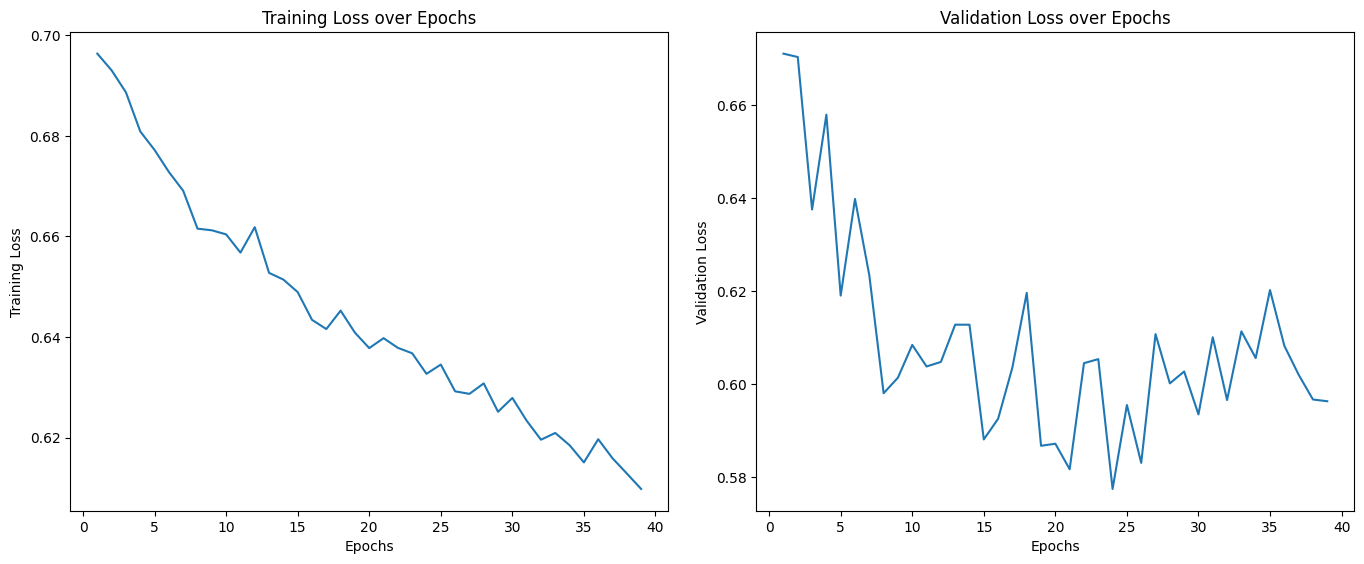

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Training Res on Left
axs[0].plot(range(1, len(train_val_dict['train_losses']) + 1), train_val_dict['train_losses'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel("Training Loss")
axs[0].set_title("Training Loss over Epochs");
axs[0].set
# Plotting Validation Res on Right
axs[1].plot(range(1, len(train_val_dict['val_losses']) + 1), train_val_dict['val_losses'])
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel("Validation Loss")
axs[1].set_title("Validation Loss over Epochs");
fig.tight_layout(pad = 2);

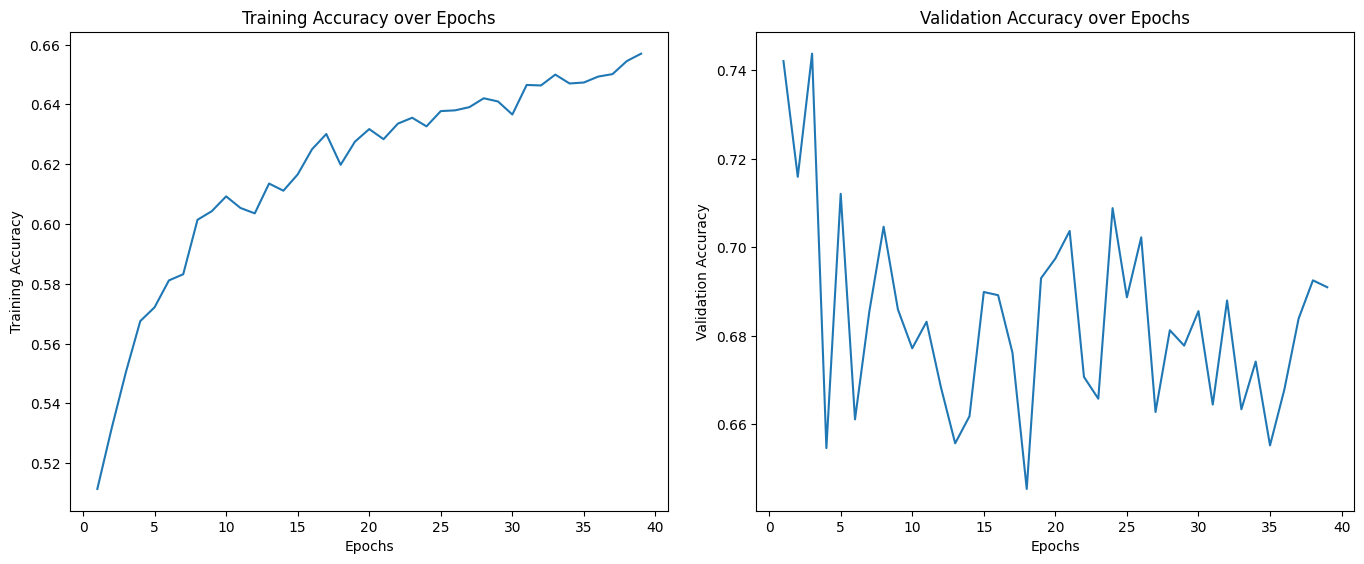

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6)) # (width, height)

# Plotting Training Res on Left
axs[0].plot(range(1, len(train_val_dict['train_accs']) + 1), train_val_dict['train_accs'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel("Training Accuracy")
axs[0].set_title("Training Accuracy over Epochs");
axs[0].set
# Plotting Validation Res on Right
axs[1].plot(range(1, len(train_val_dict['val_accs']) + 1), train_val_dict['val_accs'])
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel("Validation Accuracy")
axs[1].set_title("Validation Accuracy over Epochs");
fig.tight_layout(pad = 2); # Spacing between subplots

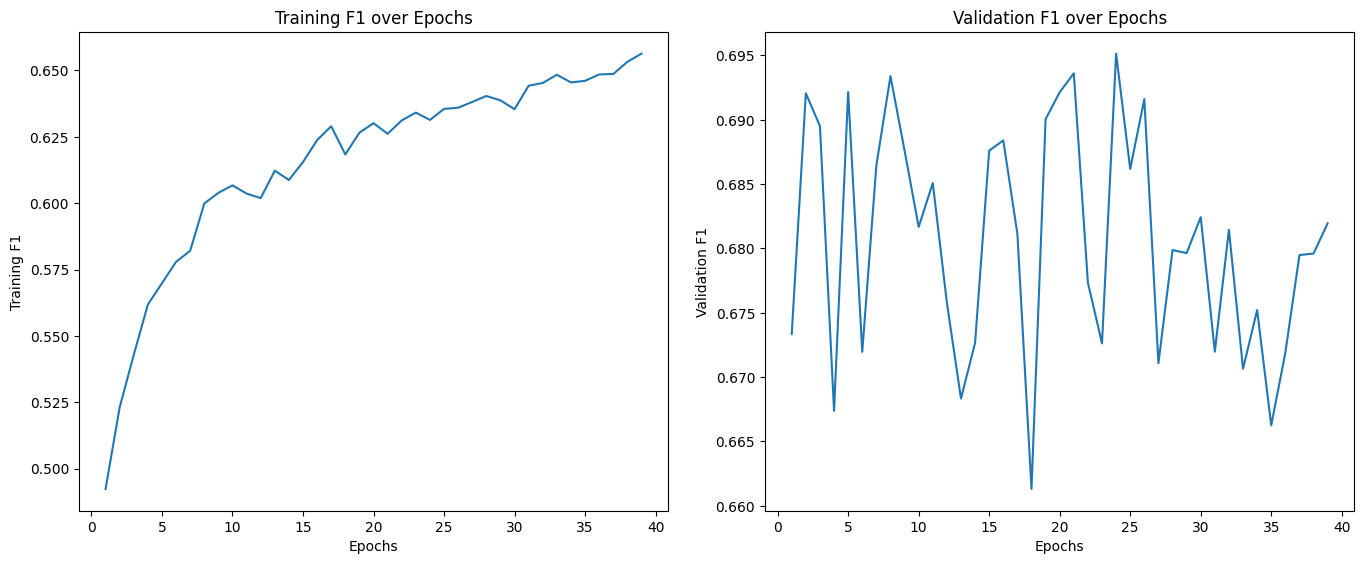

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6)) # (width, height) weighted or unweighted (DC)

# Plotting Training Res on Left
axs[0].plot(range(1, len(train_val_dict['train_f1s']) + 1), train_val_dict['train_f1s'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel("Training F1")
axs[0].set_title("Training F1 over Epochs");
axs[0].set
# Plotting Validation Res on Right
axs[1].plot(range(1, len(train_val_dict['val_f1s']) + 1), train_val_dict['val_f1s'])
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel("Validation F1")
axs[1].set_title("Validation F1 over Epochs");
fig.tight_layout(pad = 2);

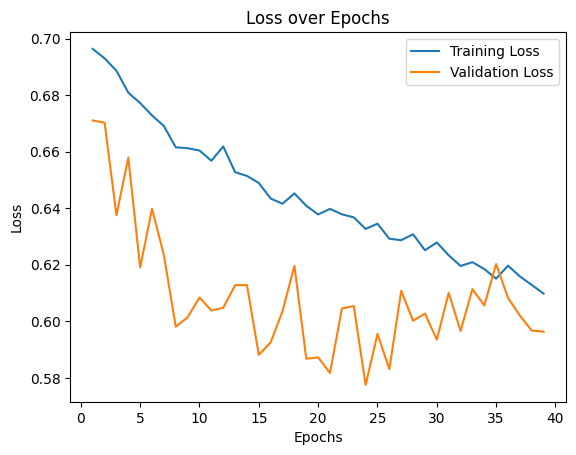

In [ ]:
plt.plot(range(1, len(train_val_dict['train_losses']) + 1), train_val_dict['train_losses'], label = "Training Loss")
plt.plot(range(1, len(train_val_dict['val_losses']) + 1), train_val_dict['val_losses'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs");

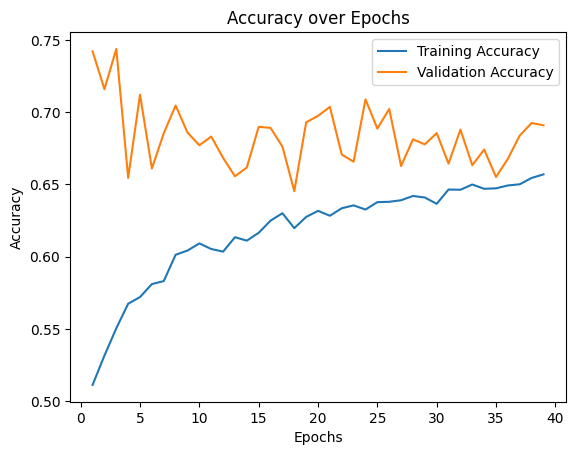

In [ ]:
plt.plot(range(1, len(train_val_dict['train_accs']) + 1), train_val_dict['train_accs'], label = "Training Accuracy")
plt.plot(range(1, len(train_val_dict['train_losses']) + 1), train_val_dict['val_accs'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs");

### Saving a model & Exporting into Torchscript for Engineering Team


Key Step: Remove all conditional statements, for loops, and use x = x.view(x.size(0), -1) instead of x = nn.Flatten() (x)

In [ ]:
# Poolsize of 4, 2 conv layer: 8 & 16 filts; nmels 128;
import torch
from torch import nn
class modded_CNN(nn.Module):
    def __init__(self):
        super(modded_CNN, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(in_channels= 1, out_channels= 8,kernel_size = 5, stride = 1, padding= 0),
                                   nn.Conv2d(in_channels= 8, out_channels= 16,kernel_size = 3, stride = 1, padding= 0)])
        self.bn = nn.ModuleList([nn.BatchNorm2d(8), nn.BatchNorm2d(16)])
        self.fc = nn.ModuleList([nn.Linear(832, 1)])
        self.pooling = nn.AvgPool2d(kernel_size = 5)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p= 0.15)

    def forward(self, x):
        x = self.pooling(self.activation(self.bn[0](self.conv[0](x))))
        x = self.pooling(self.activation(self.bn[1](self.conv[1](x))))
        #x = nn.Flatten() (x)
        x = x.view(x.size(0), -1)
        x = self.fc[0](x) # Last layer always return logits
        return x

In [ ]:
from torchsummary import summary
# Specify the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
updated_cnn = modded_CNN().to(device)

# Input is the (number of channels, image height, image width) if input is 2d, essentially the 2 dimensions of it
s = summary(updated_cnn, (1,128,345))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 124, 341]             208
       BatchNorm2d-2          [-1, 8, 124, 341]              16
              ReLU-3          [-1, 8, 124, 341]               0
         AvgPool2d-4            [-1, 8, 24, 68]               0
            Conv2d-5           [-1, 16, 22, 66]           1,168
       BatchNorm2d-6           [-1, 16, 22, 66]              32
              ReLU-7           [-1, 16, 22, 66]               0
         AvgPool2d-8            [-1, 16, 4, 13]               0
            Linear-9                    [-1, 1]             833
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.17
Forward/backward pass size (MB): 8.38
Params size (MB): 0.01
Estimated Total Size (MB): 8.56
------------------------------------------

In [ ]:
updated_cnn.load_state_dict(mlp_trainer.model.state_dict())
#model_scripted = torch.jit.script(updated_cnn)
#model_scripted.save('1020_Male_2conv1fc_CNN_model.pt')

### Validation & Test Dataset Confusion Matrix. Analyzing trends in the precision and recall for Validation Dataset

In [ ]:
df_arch_tests

,num_conv,num_filts,kernel_szs,num_fc,fc_neurons,pool_sz,mincl_loss_scalar,input_shape,DP2D,DP1D,mincl_probesh,LR
0,3,16_24_32,"(5, 5)_(3, 3)_(3, 3)",2,352_100_100_1,3,0,64_345,0.2,0.15,0.5,0.00005
1,3,16_32_48,"(5, 5)_(3, 3)_(3, 3)",2,528_200_200_1,3,0,64_345,0.2,0.15,0.5,0.00005
2,4,8_16_24_32,"(5, 5)_(3, 3)_(3, 3)_(3, 3)",3,1216_608_608_121_121_1,2,0,64_345,0.3,0.30,0.5,0.00005


Validation DS Classification Metrics

In [ ]:
val_pred_labels, val_y = mlp_trainer.evaluate(val_ds, 0.5,  val = False)

In [ ]:
from sklearn.metrics import confusion_matrix
model_conf = confusion_matrix(y_pred= val_pred_labels, y_true= val_y, labels= [0,1])
model_conf

In [ ]:
ax = sns.heatmap(model_conf,annot = True, fmt=".1f", xticklabels= dict_labels.keys(), yticklabels= dict_labels.keys())
ax.figure.set_size_inches(7,7)
ax.set_title("CNN Test Confusion Matrix");
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label");

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(val_y, val_pred_labels, target_names=dict_labels.keys()))

Test DS Classification Results

In [ ]:
test_ds = Audio_DS(df_test_map, spectrify_obj= spectrify_obj, device = "cuda")

In [ ]:
# 1 sec (10/30) 64 mels: 8, 16, 24
test_pred_labels, test_y = mlp_trainer.evaluate(test_ds, 0.5, val = False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y, test_pred_labels, target_names=dict_labels.keys()))

              precision    recall  f1-score   support

           S       0.84      0.70      0.76      7164
           I       0.31      0.49      0.38      1954

    accuracy                           0.66      9118
   macro avg       0.57      0.60      0.57      9118
weighted avg       0.72      0.66      0.68      9118



In [ ]:
# 1 sec (10/30) 64 mels: 16, 24, 32
test_pred_labels, test_y = mlp_trainer.evaluate(test_ds, 0.5,  val = False)

Test Accuracy: 0.6544
Test F1: 0.6782


In [ ]:
# 1 sec (10/30) 64 mels: 16, 32, 48
test_pred_labels, test_y = mlp_trainer.evaluate(test_ds, 0.5,  val = False)

Test Accuracy: 0.6765
Test F1: 0.6905


In [ ]:
# 1 sec (10/30) 64 mels: 8, 16, 24, 32
test_pred_labels, test_y = mlp_trainer.evaluate(test_ds, 0.5,  val = False)

Test Accuracy: 0.6767
Test F1: 0.6877


In [ ]:
from sklearn.metrics import confusion_matrix
model_conf = confusion_matrix(y_pred= test_pred_labels, y_true= test_y, labels= [0,1])
model_conf

array([[5399, 1765],
       [1185,  769]])

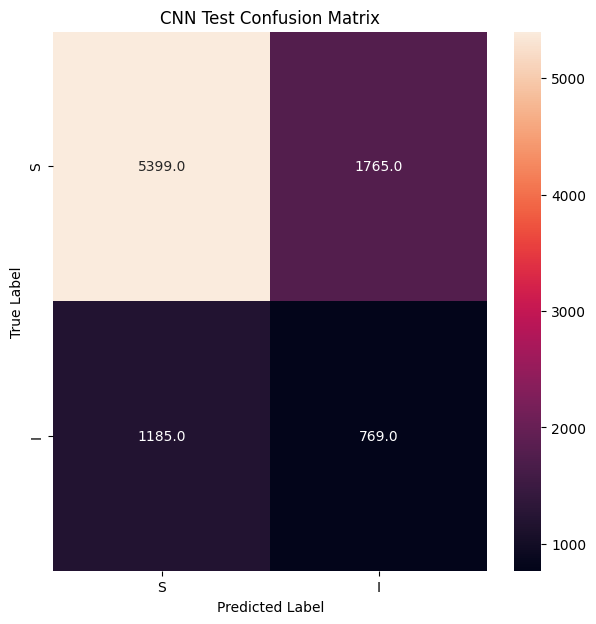

In [ ]:
ax = sns.heatmap(model_conf,annot = True, fmt=".1f", xticklabels= dict_labels.keys(), yticklabels= dict_labels.keys())
ax.figure.set_size_inches(7,7)
ax.set_title("CNN Test Confusion Matrix");
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label");

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y, test_pred_labels, target_names=dict_labels.keys()))

              precision    recall  f1-score   support

           S       0.82      0.75      0.79      7164
           I       0.30      0.39      0.34      1954

    accuracy                           0.68      9118
   macro avg       0.56      0.57      0.56      9118
weighted avg       0.71      0.68      0.69      9118



## Model Performance on Test Dataset

### **Test Dataset Classification Metrics**

In [ ]:
test_ds = Audio_DS(df_test_map, spectrify_obj= spectrify_obj, device = "cuda")

In [ ]:
test_pred_labels, test_y = mlp_trainer.evaluate(test_ds, 0.5, val = False)

In [ ]:
from sklearn.metrics import confusion_matrix
model_conf = confusion_matrix(y_pred= test_pred_labels, y_true= test_y, labels= [0,1])
model_conf

In [ ]:
ax = sns.heatmap(model_conf,annot = True, fmt=".1f", xticklabels= dict_labels.keys(), yticklabels= dict_labels.keys())
ax.figure.set_size_inches(7,7)
ax.set_title("CNN Test Confusion Matrix");
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label");

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y, test_pred_labels, target_names=dict_labels.keys()))

### Future: Exploring Focal Loss: Extension of Binary Cross Entropy Loss with Positive Weight for Minority Class & reduced weight calibration for easily classified samples

In [ ]:
import torch
import torch.nn as nn

class WeightedFocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Example usage with class weighting
criterion = WeightedFocalLoss(alpha=5, gamma=2)


In [ ]:
from torch.optim import Adam
import sklearn
import multiprocessing
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

class Trainer():
  def __init__(self, model, epochs, learning_rate, batch_size, max_train_f1, num_workers, min_class_penal, threshold, device = "cuda", optimizer_type = "Adam"):
    self.model = model.to(device)
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.device = device
    self.num_workers = num_workers
    self.max_train_f1 = max_train_f1
    if min_class_penal !=0:
      self.loss_criterion = WeightedFocalLoss(alpha = torch.tensor(min_class_penal, dtype = torch.float).to(device), gamma = torch.tensor(2.0, dtype = torch.float).to(device))
    else:
      self.loss_criterion = nn.BCEWithLogitsLoss()
    self.prob_thresh = threshold
    if optimizer_type == "Adam":
      self.optimizer = Adam(model.parameters(), learning_rate)
    self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=8, verbose=True)
  @timing
  def train(self, train_ds, val_ds, sampler, early_stop = True, L2 = True, tens_logger = None, L2_reg = 1e-5):

    # Initialize lists to store metrics, initial model weights, method for recording val_loss to do early stopping,

    losses = []
    accs = []
    f1s = []
    val_losses = []
    val_accs = []
    val_f1s = []
    weights = self.model.state_dict()
    lowest_val_f1 = 0
    num_epochs = 1  #Only for MaxTrain till training metric is certain value

    # Loading in the train dataset
    train_dataloader = DataLoader(train_ds, self.batch_size, sampler = sampler,
                                  num_workers = self.num_workers, prefetch_factor= self.num_workers * 2)

    # Conditionally establishing train till f1 less than 0.9
    epoch_f1 = 0
    while ((epoch_f1 < self.max_train_f1) and (self.optimizer.param_groups[0]['lr'] > 7e-6)):  #(Only uncomment for MaxTrain)
    #for num_epochs in range(1, self.epochs + 1):
      # Initializing the metrics for each epoch to be 0
      epoch_loss = 0
      epoch_acc = 0
      epoch_f1 = 0
      self.model.train() # Indicating training is occurring for dropout and batch normalization
      for batch, acc_labels in train_dataloader:
        batch = torch.tensor(batch.numpy(), dtype=torch.float).to(self.device)
        acc_labels = torch.tensor(acc_labels.numpy(), dtype = torch.float).to(self.device)
        prop_ds = len(batch) / len(train_ds) # Track proportion of dataset used in batch for scaling metrics per batch size
        self.optimizer.zero_grad()       # Setting gradients to 0 prior to backpropagating loss
        batch_logits = self.model(batch) # Generate logits for batch
        loss = self.loss_criterion (batch_logits, acc_labels.view(-1, 1))
        if L2:
          loss = loss + L2_reg * sum([(wei ** 2).sum() for wei in self.model.parameters()])
        loss.backward()
        self.optimizer.step()
        batch_preds = torch.squeeze(torch.sigmoid(batch_logits) >= self.prob_thresh).float() # OG Return [[1.], [0.]]
        # Compute Metrics for each batch and store as running sum (Batch level)
        epoch_loss += loss.detach().item() * prop_ds
        acc = sum(batch_preds == acc_labels) / len(acc_labels)
        epoch_acc += acc.detach().item() * prop_ds
        # Position matters: f1_score(actual, preds, average = "")
        batch_f1 = f1_score(acc_labels.cpu().numpy(),
                            batch_preds.cpu().numpy(), average = "weighted")
        # Training f1 biased by balanced batches, but want to see improvement in f1 regardless
        # Always will be higher than true f1 scores computed from entire training dataset
        epoch_f1 += batch_f1 * prop_ds

      # Run Validation call for each epoch
      val_loss, val_acc, val_f1 = self.evaluate(val_ds)

      # Scheduler updating learning rate based on validation loss decline pass threshold within epochs in patience
      self.scheduler.step(val_loss)

      # Add metric to list for each epoch
      losses.append(epoch_loss)
      accs.append(epoch_acc)
      f1s.append(epoch_f1)
      val_losses.append(val_loss)
      val_accs.append(val_acc)
      val_f1s.append(val_f1)

      # Print Results for Each Epoch
      print("Epoch %d - Loss: %.3f - Train_Acc: %.3f - Train_F1: %.3f" % (num_epochs, epoch_loss, epoch_acc, epoch_f1))
      print("              Val_loss: %.3f - Val_Acc: %.3f - Val_F1: %.3f" % (val_loss, val_acc, val_f1))

      # Early Stop Check for Each Epoch, doing based on val_f1 rather than val_loss since biased towards greater accuracy
      if early_stop:
        if (lowest_val_f1 < val_f1) and (num_epochs > 5): # Hypothesizing the early epochs results are due to random chance and want to see if that is the case
          lowest_val_f1 = val_f1
          weights = self.model.state_dict()
      # Tensorboard Metric Tracking
      if tens_logger is not None:
                tens_logger.add_scalar("Train Loss", epoch_loss, num_epochs)
                tens_logger.add_scalar("Train Accuracy", epoch_acc, num_epochs)
                tens_logger.add_scalar("Train F1", epoch_f1, num_epochs)
                tens_logger.add_scalar("Val Loss", val_loss, num_epochs)
                tens_logger.add_scalar("Val Acc", val_acc, num_epochs)
                tens_logger.add_scalar("Val F1", val_f1, num_epochs)
      # Increment num_epochs since pass over entire dataset is completed (Only for MaxTrain)
      num_epochs += 1
    # After all epochs
    if early_stop:
      self.model.load_state_dict(weights)
    return {"model": self.model, "train_accs" : accs, "train_losses" : losses,"train_f1s" : f1s,
            "val_accs" : val_accs, "val_losses" : val_losses, "val_f1s" : val_f1s}

  def evaluate(self, val_dset, val = True):
    # Initialize metrics & dataloader for validation dataset
    ep_loss = 0
    ep_acc = 0
    ep_f1 = 0
    all_preds = []
    all_labels = []
    self.model.eval()
    val_data_loader = DataLoader(val_dset, self.batch_size, shuffle = True,
                                 num_workers = self.num_workers, prefetch_factor= self.num_workers * 2)
    for batch, acc_labels in val_data_loader:
      batch = torch.tensor(batch.numpy(), dtype=torch.float).to(self.device)
      acc_labels = torch.tensor(acc_labels.numpy(), dtype = torch.float).to(self.device)
      prop_ds = len(batch) / len(val_dset)
      with torch.no_grad():
        batch_logits = self.model(batch)
        loss = self.loss_criterion (batch_logits, acc_labels.view(-1, 1))
        batch_preds = torch.squeeze(torch.sigmoid(batch_logits) >= self.prob_thresh).float()
      # Update Epoch Metrics for each batch
      ep_loss += loss.detach().item() * prop_ds
      acc = torch.sum(batch_preds == acc_labels) / len(acc_labels)
      ep_acc += acc.detach().item() * prop_ds
      # Concatenating batch preds and actual labels for batch in respective lists for DS F1 score
      all_preds.extend(batch_preds.tolist())
      all_labels.extend(acc_labels.tolist())
    # After pass over entire dataset, compute f1 score for concatenated batch_preds and labels
    # Gives a more representative look at f1, since not influenced by balanced batches
    ep_f1 =  f1_score(all_labels, all_preds, average = "weighted")
    # After epoch, depending on this is a validation run or testing dataset run
    if val == False:
      print("Test Accuracy: %.4f" % ep_acc)
      print("Test F1: %.4f" % ep_f1)
      return all_preds, all_labels

    return ep_loss, ep_acc, ep_f1